# Cloudburst Prediction System
## Analyzing Meteorological Parameters and Weather Patterns

This notebook implements a complete machine learning pipeline for predicting cloudbursts using various algorithms and provides comprehensive visualizations.

### 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Model Persistence
import joblib

print('All libraries imported successfully!')

All libraries imported successfully!


### 2. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('cloudpredictionsystemproject.csv')

print('Dataset Shape:', df.shape)
print('\n' + '='*50)
print('First 5 Rows:')
print(df.head())

Dataset Shape: (145460, 23)

First 5 Rows:
         Date Location  MinimumTemperature  MaximumTemperature  Rainfall  \
0  01-12-2008   Albury                13.4                22.9       0.6   
1  02-12-2008   Albury                 7.4                25.1       0.0   
2  03-12-2008   Albury                12.9                25.7       0.0   
3  04-12-2008   Albury                 9.2                28.0       0.0   
4  05-12-2008   Albury                17.5                32.3       1.0   

   Evaporation  Sunshine WindGustDirection  WindGustSpeed WindDirection9am  \
0          NaN       NaN                 W           44.0                W   
1          NaN       NaN               WNW           44.0              NNW   
2          NaN       NaN               WSW           46.0                W   
3          NaN       NaN                NE           24.0               SE   
4          NaN       NaN                 W           41.0              ENE   

   ... Humidity9am  Humidity3pm

In [3]:
# Dataset Information
print('Dataset Information:')
print(df.info())
print('\n' + '='*50)
print('\nStatistical Summary:')
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                145460 non-null  object 
 1   Location            145460 non-null  object 
 2   MinimumTemperature  143975 non-null  float64
 3   MaximumTemperature  144199 non-null  float64
 4   Rainfall            142199 non-null  float64
 5   Evaporation         82670 non-null   float64
 6   Sunshine            75625 non-null   float64
 7   WindGustDirection   135134 non-null  object 
 8   WindGustSpeed       135197 non-null  float64
 9   WindDirection9am    134894 non-null  object 
 10  WindDirection3pm    141232 non-null  object 
 11  WindSpeed9am        143693 non-null  float64
 12  WindSpeed3pm        142398 non-null  float64
 13  Humidity9am         142806 non-null  float64
 14  Humidity3pm         140953 non-null  float64
 15  Pressure9am  

In [4]:
# Check missing values
print('Missing Values Count:')
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_data, 'Percentage': missing_percent})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

Missing Values Count:
                    Missing_Count  Percentage
Sunshine                    69835   48.009762
Evaporation                 62790   43.166506
Cloud3pm                    59358   40.807095
Cloud9am                    55888   38.421559
Pressure9am                 15065   10.356799
Pressure3pm                 15028   10.331363
WindDirection9am            10566    7.263853
WindGustDirection           10326    7.098859
WindGustSpeed               10263    7.055548
Humidity3pm                  4507    3.098446
WindDirection3pm             4228    2.906641
Temperature3pm               3609    2.481094
CloudBurstTomorrow           3267    2.245978
Rainfall                     3261    2.241853
CloudBurst Today             3261    2.241853
WindSpeed3pm                 3062    2.105046
Humidity9am                  2654    1.824557
Temperature9am               1767    1.214767
WindSpeed9am                 1767    1.214767
MinimumTemperature           1485    1.020899
MaximumTempe

In [5]:
# Target variable distribution
print('Target Variable Distribution:')
print('\nCloudBurst Today:')
print(df['CloudBurst Today'].value_counts())
print('\nCloudBurstTomorrow:')
print(df['CloudBurstTomorrow'].value_counts())

Target Variable Distribution:

CloudBurst Today:
No     110319
Yes     31880
Name: CloudBurst Today, dtype: int64

CloudBurstTomorrow:
No     110316
Yes     31877
Name: CloudBurstTomorrow, dtype: int64


### 3. Data Visualization

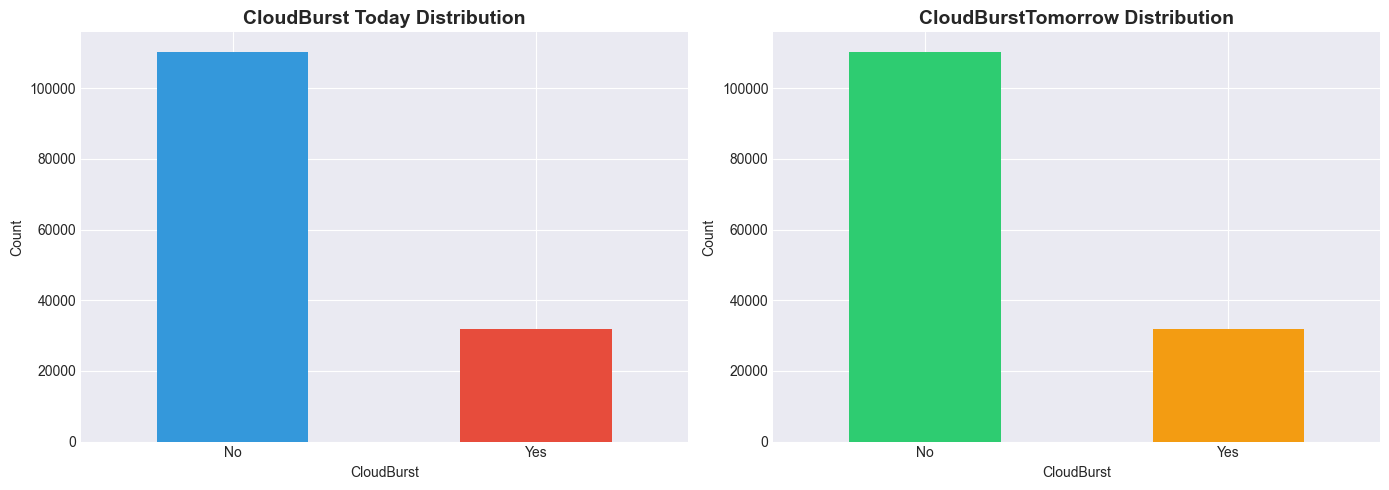

In [6]:
# Target variable distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['CloudBurst Today'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('CloudBurst Today Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('CloudBurst')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

df['CloudBurstTomorrow'].value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f39c12'])
axes[1].set_title('CloudBurstTomorrow Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('CloudBurst')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

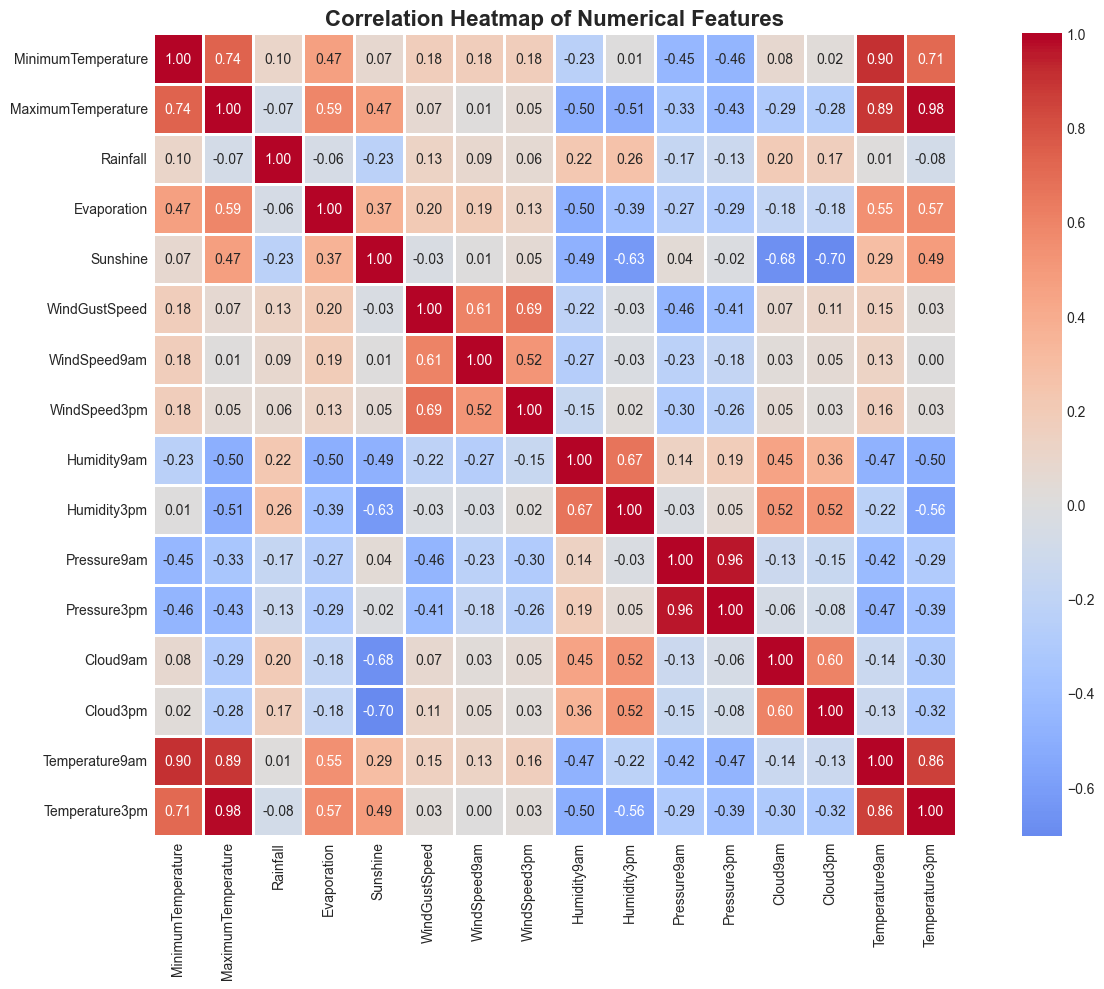

In [7]:
# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

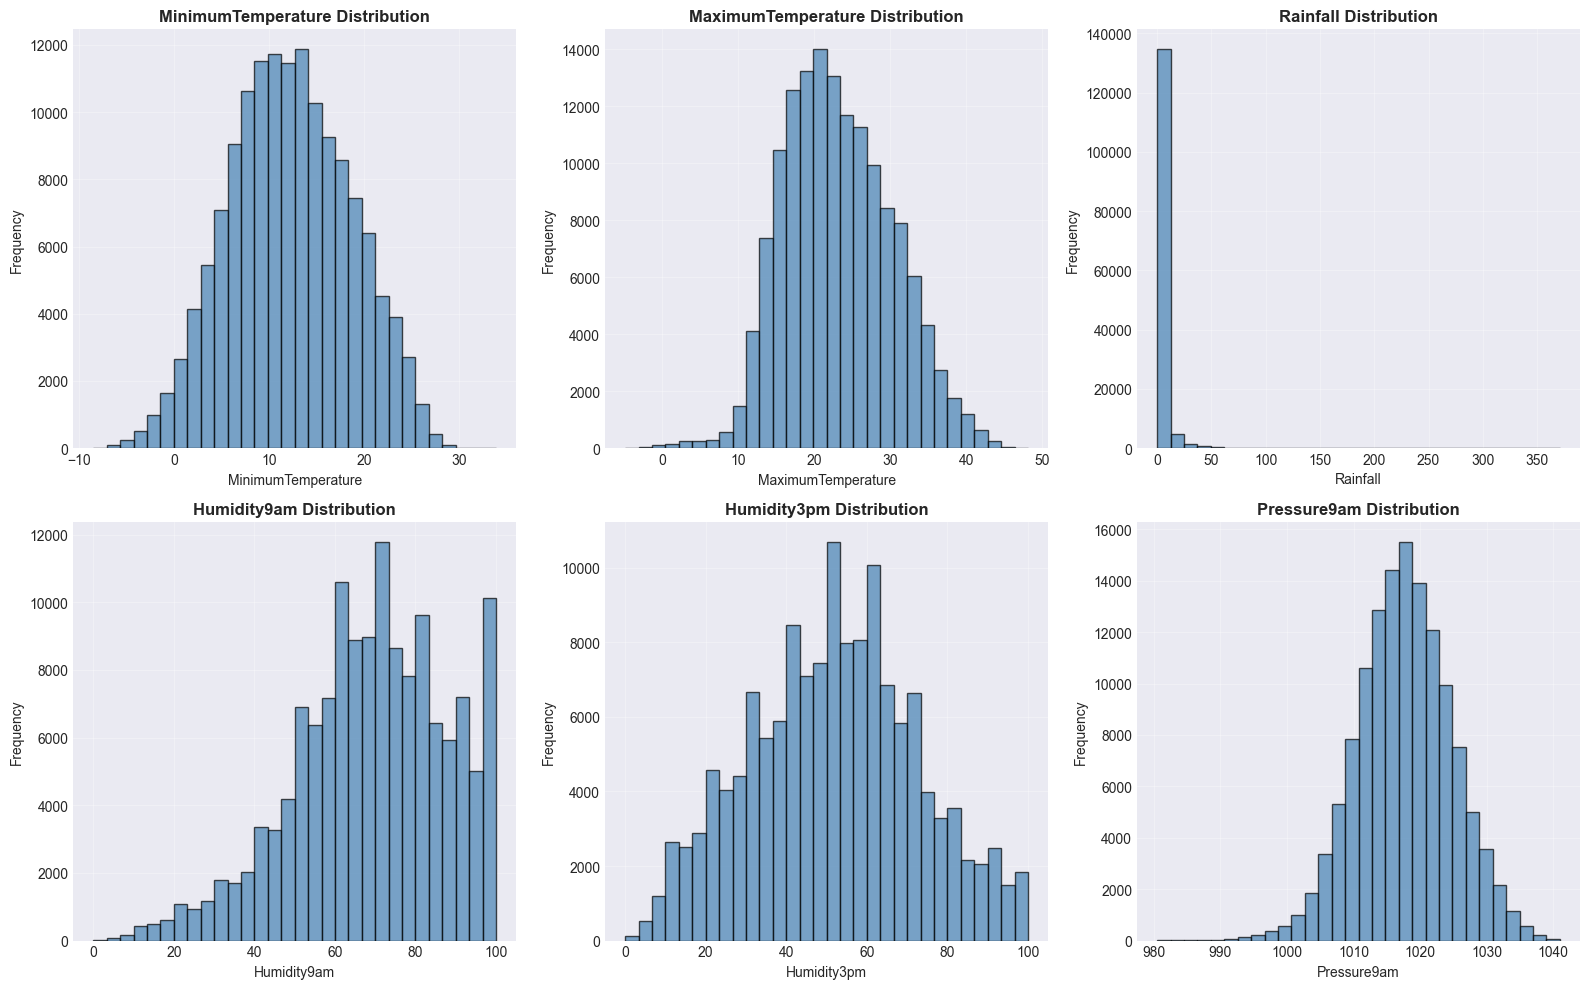

In [8]:
# Distribution of key meteorological parameters
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

key_features = ['MinimumTemperature', 'MaximumTemperature', 'Rainfall', 
                'Humidity9am', 'Humidity3pm', 'Pressure9am']

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        axes[idx].hist(df[feature].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Data Preprocessing

In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop Date and Location columns as they are not useful for prediction
df_processed = df_processed.drop(['Date', 'Location'], axis=1)

print('Columns after dropping Date and Location:')
print(df_processed.columns.tolist())

Columns after dropping Date and Location:
['MinimumTemperature', 'MaximumTemperature', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDirection', 'WindGustSpeed', 'WindDirection9am', 'WindDirection3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temperature9am', 'Temperature3pm', 'CloudBurst Today', 'CloudBurstTomorrow']


In [10]:
# Encode categorical variables (Wind Direction columns)
categorical_cols = ['WindGustDirection', 'WindDirection9am', 'WindDirection3pm']
label_encoders = {}

for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = df_processed[col].fillna('Unknown')
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

print('Categorical variables encoded successfully!')

Categorical variables encoded successfully!


In [11]:
# Separate features and targets
# Predicting CloudBurstTomorrow
X = df_processed.drop(['CloudBurst Today', 'CloudBurstTomorrow'], axis=1)
y = df_processed['CloudBurstTomorrow']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

print('Features shape:', X.shape)
print('Target shape:', y.shape)
print('Target classes:', le_target.classes_)

Features shape: (145460, 19)
Target shape: (145460,)
Target classes: ['No' 'Yes' nan]


In [12]:
# Handle missing values with imputation
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print('Missing values after imputation:', X.isnull().sum().sum())

Missing values after imputation: 0


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training set size:', X_train.shape)
print('Testing set size:', X_test.shape)

Training set size: (116368, 19)
Testing set size: (29092, 19)


In [14]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature scaling completed!')

Feature scaling completed!


### 5. Model Training and Comparison

In [17]:
# Define multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    # 'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}

print(f'Total models to train: {len(models)}')

Total models to train: 8


In [18]:
# Train and evaluate all models
results = []
trained_models = {}

print('Training models...\n')
print('='*80)

for name, model in models.items():
    print(f'\nTraining {name}...')
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Score': cv_mean
    })
    
    # Store trained model
    trained_models[name] = model
    
    print(f'{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, CV Score: {cv_mean:.4f}')

print('\n' + '='*80)
print('All models trained successfully!')

Training models...


Training Logistic Regression...
Logistic Regression - Accuracy: 0.8239, F1-Score: 0.8028, CV Score: 0.8220

Training Decision Tree...
Decision Tree - Accuracy: 0.7582, F1-Score: 0.7609, CV Score: 0.7567

Training Random Forest...
Random Forest - Accuracy: 0.8414, F1-Score: 0.8270, CV Score: 0.8399

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.8366, F1-Score: 0.8225, CV Score: 0.8346

Training XGBoost...
XGBoost - Accuracy: 0.8443, F1-Score: 0.8326, CV Score: 0.8409

Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.8220, F1-Score: 0.8081, CV Score: 0.8158

Training Naive Bayes...
Naive Bayes - Accuracy: 0.7899, F1-Score: 0.7831, CV Score: 0.7890

Training AdaBoost...
AdaBoost - Accuracy: 0.8264, F1-Score: 0.8098, CV Score: 0.8233

All models trained successfully!


In [19]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print('\nModel Comparison Results:')
print('='*80)
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print('\nResults saved to model_comparison_results.csv')


Model Comparison Results:
              Model  Accuracy  Precision   Recall  F1-Score  CV Score
            XGBoost  0.844253   0.836651 0.844253  0.832611  0.840901
      Random Forest  0.841434   0.835401 0.841434  0.827023  0.839861
  Gradient Boosting  0.836587   0.828806 0.836587  0.822505  0.834628
           AdaBoost  0.826447   0.815595 0.826447  0.809841  0.823345
Logistic Regression  0.823869   0.795564 0.823869  0.802805  0.822039
K-Nearest Neighbors  0.822047   0.809544 0.822047  0.808145  0.815774
        Naive Bayes  0.789942   0.778419 0.789942  0.783064  0.789023
      Decision Tree  0.758181   0.764005 0.758181  0.760947  0.756737

Results saved to model_comparison_results.csv


### 6. Visualization of Model Performance

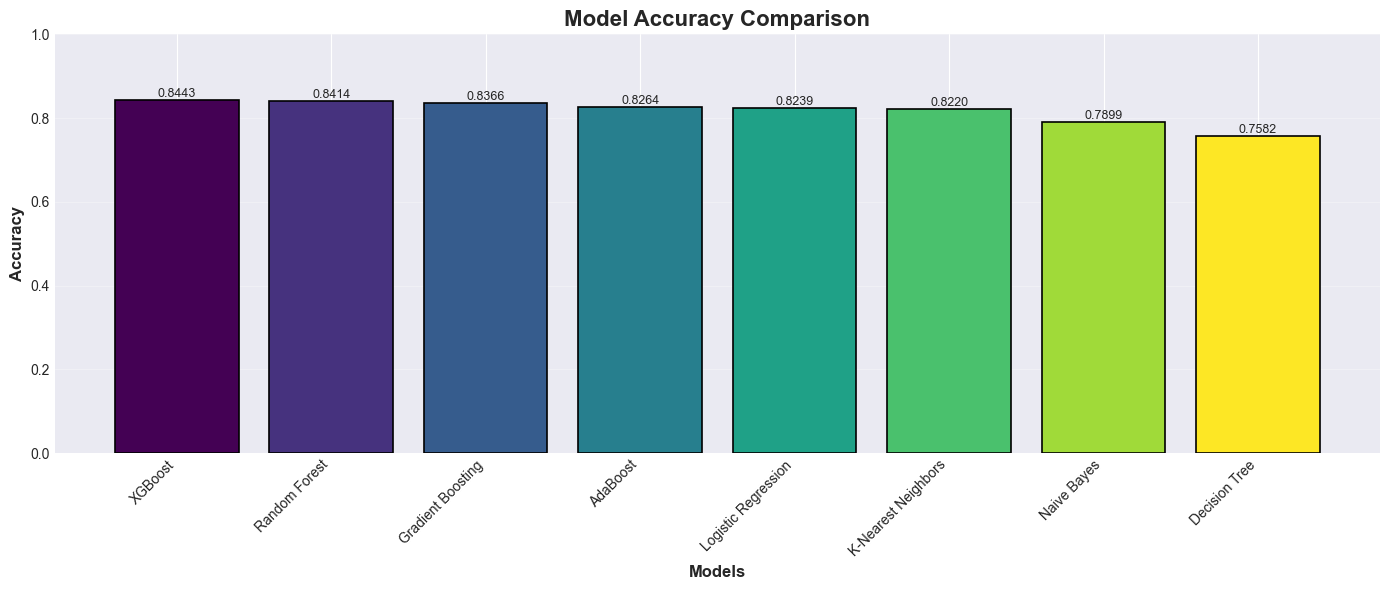

In [20]:
# Model Accuracy Comparison
plt.figure(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

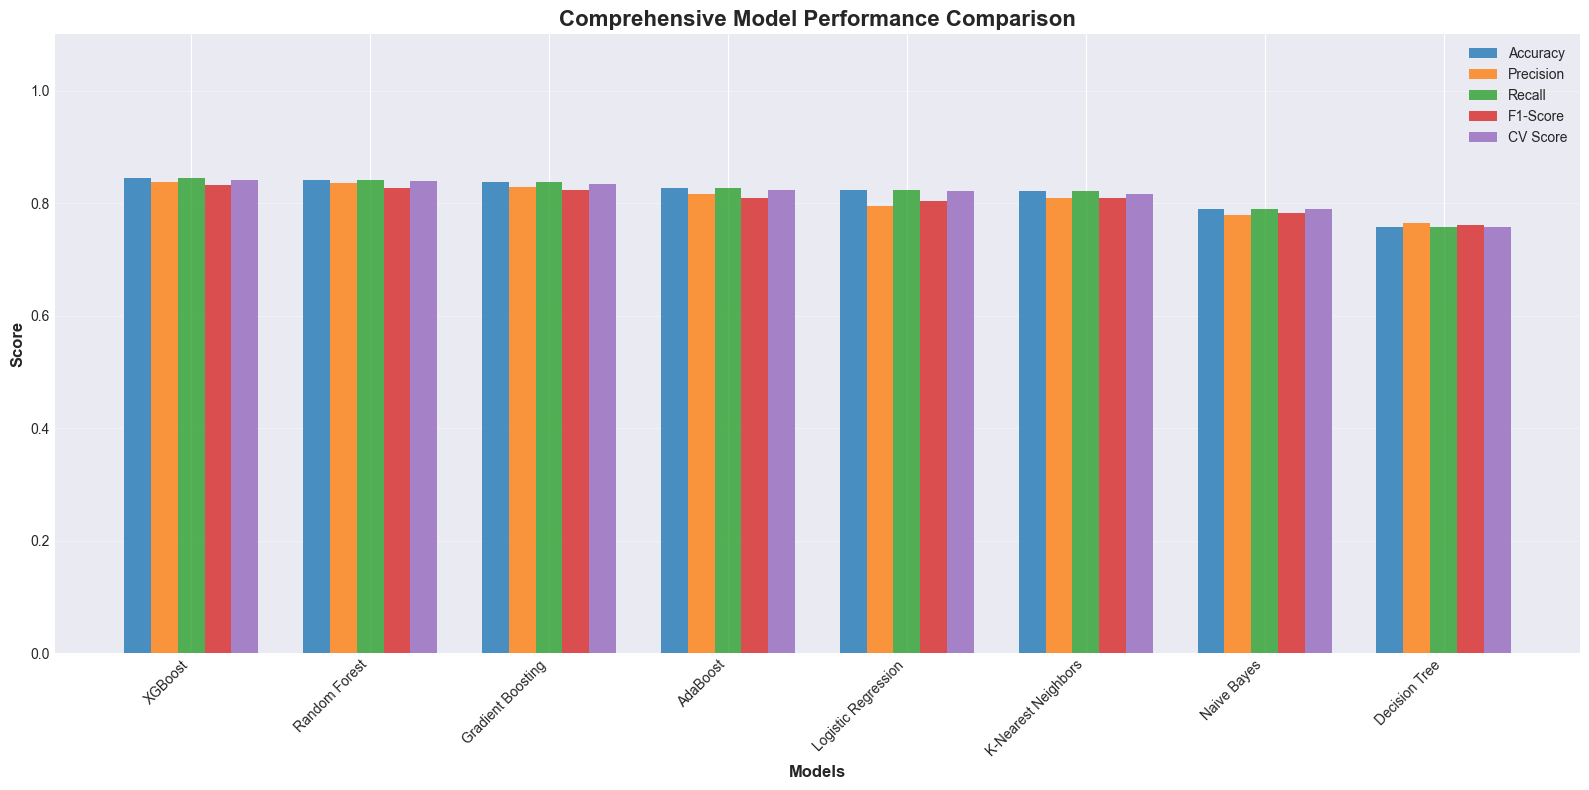

In [21]:
# Multiple Metrics Comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Score']
x = np.arange(len(results_df))
width = 0.15

fig, ax = plt.subplots(figsize=(16, 8))

for idx, metric in enumerate(metrics_to_plot):
    offset = width * (idx - 2)
    ax.bar(x + offset, results_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend(loc='best', fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

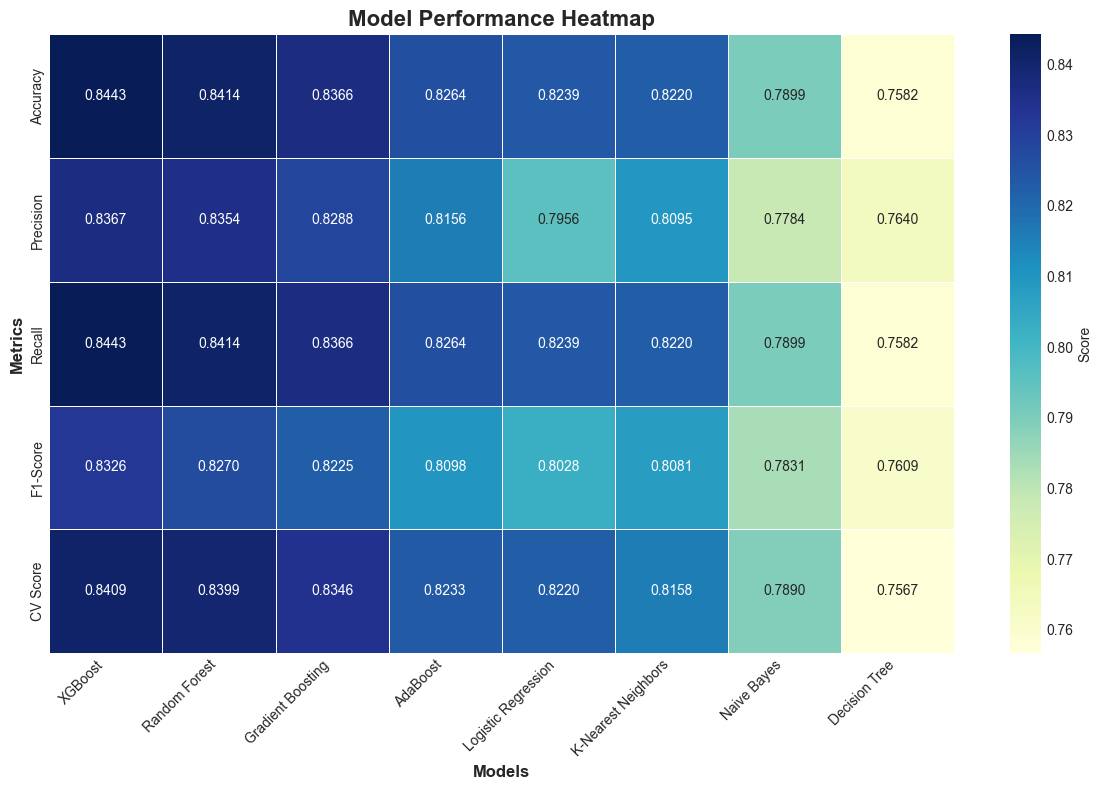

In [22]:
# Heatmap of model performance
plt.figure(figsize=(12, 8))
heatmap_data = results_df.set_index('Model')[metrics_to_plot].T
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 7. Best Model Analysis

In [23]:
# Identify the best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f'\nBest Model: {best_model_name}')
print('='*80)
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"CV Score: {results_df.iloc[0]['CV Score']:.4f}")


Best Model: XGBoost
Accuracy: 0.8443
Precision: 0.8367
Recall: 0.8443
F1-Score: 0.8326
CV Score: 0.8409


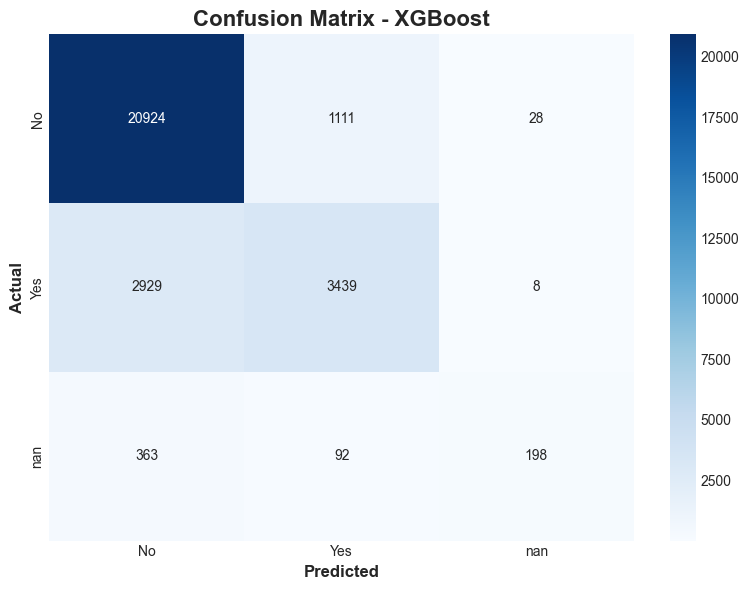

In [24]:
# Confusion Matrix for Best Model
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Classification Report
print('\nClassification Report for Best Model:')
print('='*80)
# print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))


Classification Report for Best Model:


In [27]:
# ROC Curve for Best Model (if binary classification)
if len(le_target.classes_) == 2 and hasattr(best_model, 'predict_proba'):
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
    roc_auc = roc_auc_score(y_test, y_pred_proba_best)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curve - {best_model_name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'\nROC-AUC Score: {roc_auc:.4f}')

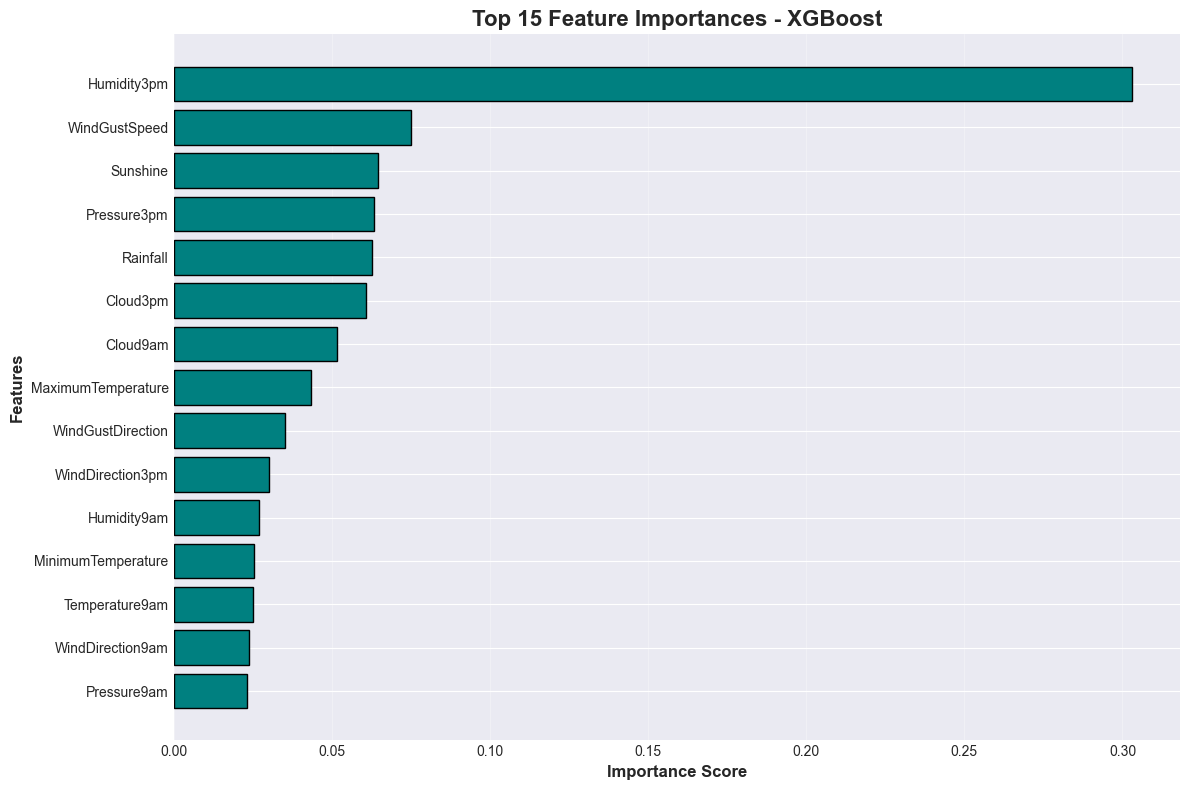


Top 10 Important Features:
           Feature  Importance
       Humidity3pm    0.303037
     WindGustSpeed    0.075054
          Sunshine    0.064637
       Pressure3pm    0.063236
          Rainfall    0.062624
          Cloud3pm    0.060820
          Cloud9am    0.051616
MaximumTemperature    0.043531
 WindGustDirection    0.035345
  WindDirection3pm    0.030098


In [28]:
# Feature Importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], 
             color='teal', edgecolor='black')
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nTop 10 Important Features:')
    print(feature_importance.head(10).to_string(index=False))

### 8. Model Saving

In [29]:
# Save the best model
joblib.dump(best_model, 'best_cloudburst_model.pkl')
print(f'Best model ({best_model_name}) saved as best_cloudburst_model.pkl')

# Save the scaler and label encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_target, 'label_encoder.pkl')
joblib.dump(imputer, 'imputer.pkl')
print('Scaler, Label Encoder, and Imputer saved successfully!')

Best model (XGBoost) saved as best_cloudburst_model.pkl
Scaler, Label Encoder, and Imputer saved successfully!


In [ ]:
# Save all trained models
for name, model in trained_models.items():
    filename = f"model_{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    
print(f'\nAll {len(trained_models)} models saved successfully!')

### 9. Model Prediction Example

In [30]:
# Example prediction with the best model
print('Example Prediction with Best Model:')
print('='*80)

# Take first 5 test samples
sample_data = X_test_scaled[:5]
predictions = best_model.predict(sample_data)
predictions_labels = le_target.inverse_transform(predictions)

if hasattr(best_model, 'predict_proba'):
    probabilities = best_model.predict_proba(sample_data)
    
    for i in range(len(predictions)):
        print(f'\nSample {i+1}:')
        print(f'  Predicted: {predictions_labels[i]}')
        print(f'  Actual: {le_target.inverse_transform([y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]])[0]}')
        print(f'  Probability: No={probabilities[i][0]:.4f}, Yes={probabilities[i][1]:.4f}')
else:
    for i in range(len(predictions)):
        print(f'\nSample {i+1}:')
        print(f'  Predicted: {predictions_labels[i]}')
        print(f'  Actual: {le_target.inverse_transform([y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]])[0]}')

Example Prediction with Best Model:

Sample 1:
  Predicted: Yes
  Actual: Yes
  Probability: No=0.1886, Yes=0.7956

Sample 2:
  Predicted: No
  Actual: No
  Probability: No=0.8832, Yes=0.1157

Sample 3:
  Predicted: No
  Actual: No
  Probability: No=0.6083, Yes=0.3528

Sample 4:
  Predicted: No
  Actual: No
  Probability: No=0.9569, Yes=0.0416

Sample 5:
  Predicted: No
  Actual: No
  Probability: No=0.7877, Yes=0.2023


### 10. Summary and Conclusion

In [31]:
print('\n' + '='*80)
print('CLOUDBURST PREDICTION SYSTEM - SUMMARY')
print('='*80)
print(f'\nDataset Size: {df.shape}')
print(f'Number of Features: {X.shape[1]}')
print(f'Training Samples: {X_train.shape[0]}')
print(f'Testing Samples: {X_test.shape[0]}')
print(f'\nTotal Models Trained: {len(models)}')
print(f'\nBest Model: {best_model_name}')
print(f'Best Accuracy: {results_df.iloc[0]["Accuracy"]:.4f}')
print(f'Best F1-Score: {results_df.iloc[0]["F1-Score"]:.4f}')
print('\nAll models and visualizations have been saved successfully!')
print('='*80)


CLOUDBURST PREDICTION SYSTEM - SUMMARY

Dataset Size: (145460, 23)
Number of Features: 19
Training Samples: 116368
Testing Samples: 29092

Total Models Trained: 8

Best Model: XGBoost
Best Accuracy: 0.8443
Best F1-Score: 0.8326

All models and visualizations have been saved successfully!
